In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import tensorflow as tf
from ipywidgets import interact
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer
from tqdm import tqdm
import datetime


2023-04-27 21:27:30.107825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


In [4]:
noisy_stft.get_data().shape

(10000, 129, 9, 2)

In [5]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,0]
labels = pure_stft.get_data()[:,:,:,0]

stride_reduce = 100
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,0]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,0]

examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

# build the dataset from tensorflow functions
train_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))
test_dataset = tf.data.Dataset.from_tensor_slices((examples_test, labels_test))

2023-04-27 21:27:34.849642: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-27 21:27:34.850453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-27 21:27:34.899617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 21:27:34.899866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.93GiB deviceMemoryBandwidth: 208.91GiB/s
2023-04-27 21:27:34.899893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-27 21:27:34.901541: I tensorflow/stream_executor/platform/def

In [6]:
train_dataset
# test_dataset

<TensorSliceDataset shapes: ((129, 9), (129, 9)), types: (tf.float64, tf.float64)>

In [7]:
input_shape = (129, 9 , 2)
input_shape = (129, 9)

In [8]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 2000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
dropout_rate = 0.2
factor = 8

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(units = 125*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 50*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate),


    tf.keras.layers.Dense(units = 129*9, activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Conv2D(3,2, activation='relu', input_shape=input_shape)
    tf.keras.layers.Reshape(target_shape=input_shape)
])

model.compile(optimizer="adam",
              loss="mse",
              )

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1161)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1162000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               600600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               240400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0

In [11]:
model.fit(train_dataset,validation_data=test_dataset, epochs=200)


Epoch 1/200


2023-04-27 21:27:44.437476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-27 21:27:44.459224: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593615000 Hz
2023-04-27 21:27:44.516922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


20/20 [==============================] - 1s 28ms/step - loss: 9.8740e-05 - val_loss: 5.7143e-05
Epoch 2/200
20/20 [==============================] - 0s 15ms/step - loss: 6.0201e-05 - val_loss: 5.2793e-05
Epoch 3/200
20/20 [==============================] - 0s 15ms/step - loss: 5.4976e-05 - val_loss: 4.8952e-05
Epoch 4/200
20/20 [==============================] - 0s 15ms/step - loss: 5.0133e-05 - val_loss: 4.5866e-05
Epoch 5/200
20/20 [==============================] - 0s 15ms/step - loss: 4.5803e-05 - val_loss: 4.2814e-05
Epoch 6/200
20/20 [==============================] - 0s 14ms/step - loss: 4.0966e-05 - val_loss: 4.0714e-05
Epoch 7/200
20/20 [==============================] - 0s 15ms/step - loss: 3.6927e-05 - val_loss: 3.9028e-05
Epoch 8/200
20/20 [==============================] - 0s 15ms/step - loss: 3.2801e-05 - val_loss: 3.7805e-05
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 2.9436e-05 - val_loss: 3.6606e-05
Epoch 10/200
20/20 [====================

## Looking at predictions
Inspecting the predictions of the model on the training set.

In [12]:
predictions = model.predict(examples[:10000,:,:])

In [13]:
np.var(predictions)

0.00012228428

In [14]:
predictions.shape

def plot_example(index):
    prediction = predictions[index]
    actual = labels[index]
    noisy = examples[index]
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4)
    ax2.imshow(prediction, aspect = "auto")
    ax3.imshow(actual, aspect= "auto")
    ax1.imshow(noisy, aspect="auto")
    ax4.imshow(actual-prediction, aspect="auto")
    plt.show()

In [15]:
interact(plot_example, index=(0, 9999, 1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot_example(index)>

In [16]:
def plot_time_domain( index):

    test_noisy = noisy_stft.get_data()[index,:,:,0]
    test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

    test_pure = labels[index,:,:]
    test_pure_phase = noisy_stft.get_data()[index,:,:,1]

    model_amp = predictions[index]
    noisy_phase = noisy_stft.get_data()[index,:,:,1]

    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [17]:
interact(plot_time_domain, index = (0,9999,1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot_time_domain(index)>

## Visualize the effect on the test set
Previous visualizations were for the training set only.

Check the influence of the test set here.

In [18]:
predictions_test = model.predict(examples_test)

In [19]:
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,0]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,0]

examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

In [20]:
def plot_time_domain_test( index):

    # get the test set prediction
    test_noisy = examples_test[index]
    test_noisy_phase = examples_test_phase[index]
    
    # the pure example from the test set
    test_pure = labels_test[index]
    test_pure_phase = labels_test_phase[index]

    model_amp = predictions_test[index]
    noisy_phase = examples_test_phase[index]
    
    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [21]:
interact(plot_time_domain_test, index = (0,1000,1))

interactive(children=(IntSlider(value=500, description='index', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.plot_time_domain_test(index)>

## Store the model
Storing the model after a long training session.

In [69]:
model_folder = "model/"

In [70]:

# Get the current date
now = datetime.datetime.now()

# Format the date as "day-month-year"
date_str = now.strftime("%d-%m-h%H%M")

# 

# Parameter count
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


model_name = f"model-{date_str}-p{trainableParams}"

In [71]:


path = model_folder + model_name
model.save(path)

INFO:tensorflow:Assets written to: model/model-29-03-h1401-p2941361/assets


## Analysis of maximum values
Looking at maximum values of amplitude over the whole array

In [147]:
test_example = noisy_stft.get_data()[0]
shape = test_example.shape
test_example_reshaped = noisy_stft.get_data()[0].reshape((1, shape[0], shape[1], shape[2]))

test_pure = pure_stft.get_data()[0]

In [148]:
test_pure[:,:,0].max()

0.1167289817731223

Todo
Normalize the phase and amplitude values..

In [27]:
amps_noisy =noisy_stft.get_data()[:,:,:,0]

In [28]:
amps_noisy_flattened = amps_noisy.flatten()

(array([1.0101877e+07, 1.1225070e+06, 1.9600700e+05, 1.0042300e+05,
        5.1438000e+04, 2.1964000e+04, 9.8380000e+03, 4.6260000e+03,
        1.1690000e+03, 1.5100000e+02]),
 array([2.14359953e-11, 1.67539747e-02, 3.35079495e-02, 5.02619242e-02,
        6.70158989e-02, 8.37698737e-02, 1.00523848e-01, 1.17277823e-01,
        1.34031798e-01, 1.50785773e-01, 1.67539747e-01]),
 <BarContainer object of 10 artists>)

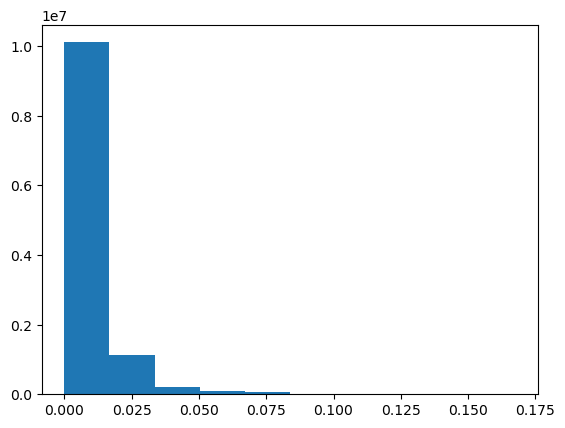

In [29]:
plt.hist(amps_noisy_flattened)

In [30]:
amps_noisy_max = amps_noisy.max(axis=2).max(axis=1)

In [31]:
amps_noisy_max.shape

(10000,)

(array([ 153.,  364., 2132., 2197., 1479., 1392., 1000.,  879.,  345.,
          59.]),
 array([0.04645806, 0.05856623, 0.0706744 , 0.08278256, 0.09489073,
        0.1069989 , 0.11910707, 0.13121524, 0.14332341, 0.15543158,
        0.16753975]),
 <BarContainer object of 10 artists>)

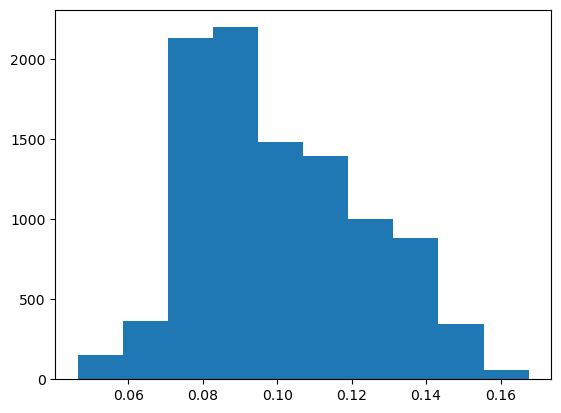

In [32]:
plt.hist(amps_noisy_max)